# Variables exploration & selection

## Libraries

In [1]:
import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

blue_colors = [
    "#D9EDFF",
    "#C1E2FF",
    "#A8D5FF",
    "#8AC6FF",
    "#6BB6FF",
    "#4A9EE5",
    "#2E86DE",
    "#0066C0",
    "#0055A5",
    "#003D82"
]

/Users/diegolozoya/Documents/ITESO/Semestre 8/CreditModels/Repos/CreditScoringModel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
def histogram(probabilities, y_test):

    plt.figure()
    color_idx = [1, 5, 9]
    for class_idx in range(3):
        sns.kdeplot(
            probabilities[y_test == class_idx, class_idx],
            color=blue_colors[color_idx[class_idx]],
            fill=True,          # fills area under curve
            alpha=0.3,          # transparency
            linewidth=2,
            label=f"Class {class_idx}"
        )

    plt.title("Probability Density (Correct Class)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importance': importances
    })
    model_importance = model_importance.sort_values(by='Importance', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [blue_colors[-1], blue_colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importance", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importance"]):
          plt.text(value - 0.001, index, f"{value:.4f}", va="center", ha='right')
    plt.xlabel('Importance')
    plt.xlim(0, max(model_importance["Importance"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} most important variables ({importance_type}-type)')
    plt.show()
 
def shap_plot(X_test, model, n_var):
    X_shap = X_test.sample(int(len(X_test)*0.8), random_state=42)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=n_var)
    plt.show()

    return shap_values

## Classification Model

In [3]:
def xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        reg_lambda=1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        tree_method='hist',
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    probabilities = model.predict_proba(X_test)
    return model, probabilities

## Results

In [4]:
df = pd.read_csv('Data/clean_train.csv')

df['Credit_Score'] = df['Credit_Score'].map({
    'Poor': 0,
    'Standard': 1,
    'Good': 2
})

target = 'Credit_Score'
y = df[target]

X = df.drop(columns=["Customer_ID", "ID", "Name", "SSN", "Month", target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model, probabilities = xgboost(X_train, X_test, y_train, y_test)

[0]	validation_0-mlogloss:0.98228	validation_1-mlogloss:0.98211
[100]	validation_0-mlogloss:0.68362	validation_1-mlogloss:0.68124
[200]	validation_0-mlogloss:0.66634	validation_1-mlogloss:0.66704
[300]	validation_0-mlogloss:0.65591	validation_1-mlogloss:0.66003
[399]	validation_0-mlogloss:0.64744	validation_1-mlogloss:0.65462


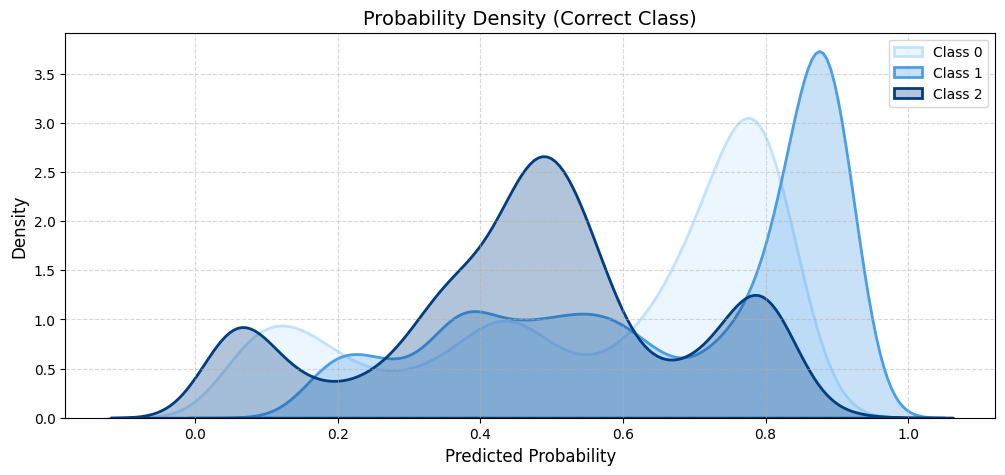

In [5]:
histogram(probabilities, y_test)

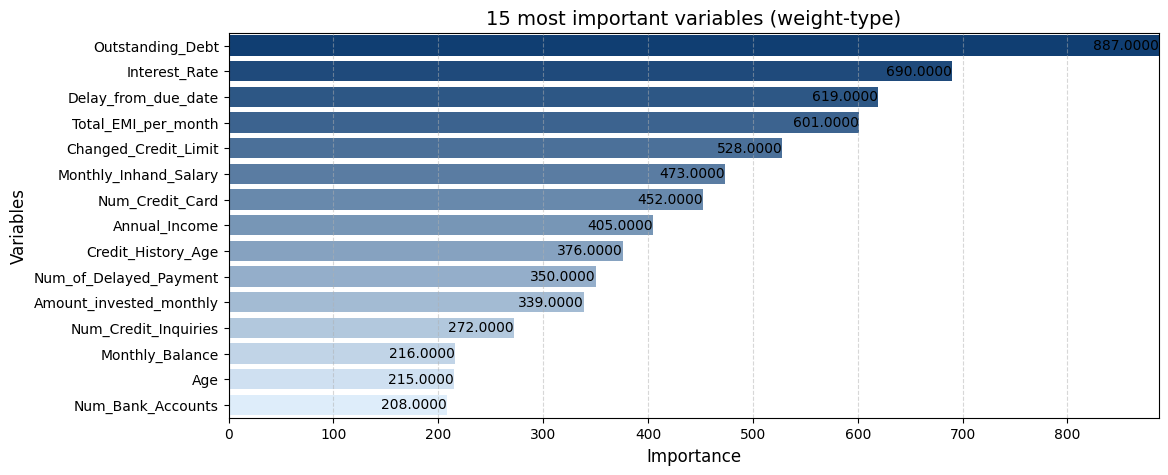

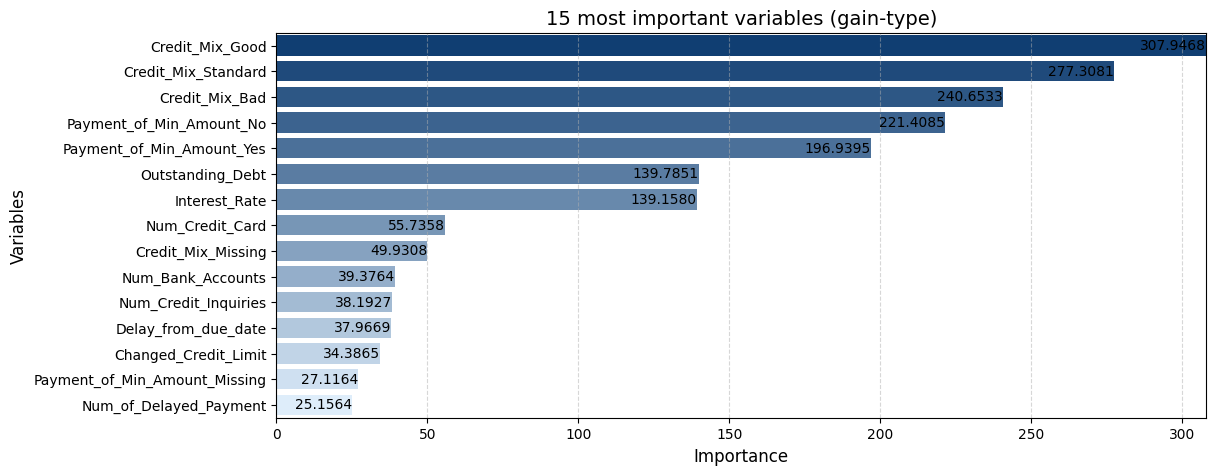

In [6]:
importancia_weight_dict = model.get_booster().get_score(importance_type='weight')
importancia_gain_dict = model.get_booster().get_score(importance_type='gain')

# Separar nombres y valores
features_weight = list(importancia_weight_dict.keys())
valores_weight = list(importancia_weight_dict.values())

features_gain = list(importancia_gain_dict.keys())
valores_gain = list(importancia_gain_dict.values())

importance(features_weight, valores_weight, 15, 'weight')
importance(features_gain, valores_gain, 15, 'gain')

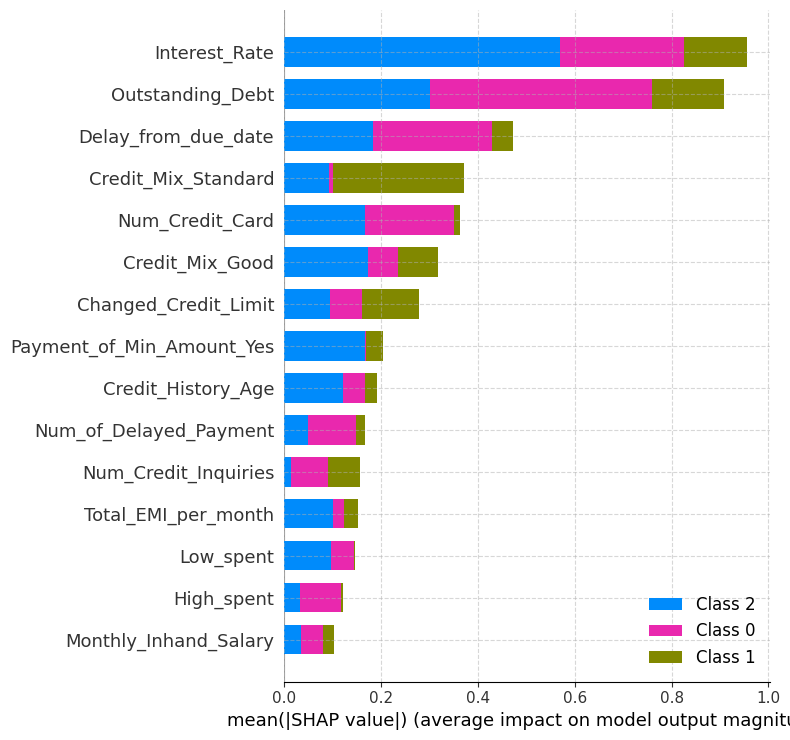

array([[[-2.50316877e-03, -5.19383978e-03,  6.36718702e-03],
        [-4.76361029e-02, -2.62010396e-02,  2.12652475e-01],
        [-4.99076881e-02,  5.31152114e-02,  2.57445090e-02],
        ...,
        [-1.02944614e-06,  4.66281374e-04, -3.99634149e-03],
        [ 2.16265908e-05,  2.32175851e-04, -1.90942474e-02],
        [-3.08216666e-03,  4.73433584e-02, -2.62703449e-01]],

       [[ 3.38971149e-05,  1.48078764e-03, -1.45392083e-02],
        [-6.98481780e-03,  1.04012415e-02, -3.07539012e-03],
        [ 7.11583346e-03, -1.61478519e-02, -1.05605051e-02],
        ...,
        [-1.02944614e-06,  4.66281374e-04, -3.99634149e-03],
        [ 2.16265908e-05,  6.50088186e-04, -1.55912368e-02],
        [-3.10865557e-03,  4.69183736e-02, -2.23478526e-01]],

       [[-1.77284144e-03, -6.45903545e-03, -9.68704815e-04],
        [-8.16499591e-02, -2.30599586e-02,  1.89011171e-01],
        [-1.10875145e-01,  4.71612625e-02,  7.54548311e-02],
        ...,
        [-1.02944614e-06,  2.77500600e-04,

In [7]:
shap_plot(X_test, model, 15)